In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions
from astropy.coordinates import search_around_sky

In [2]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [3]:
from jwst_plots import JWSTCatalog
from jwst_plots import make_cat_use
import cutout_manager as cm

In [4]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [5]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

# Load Catalog

In [6]:
cat_use = make_cat_use()

In [7]:
fn_405 = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d-perfilt64.fits'
ww = WCS(fits.open(fn_405)[0].header)

In [8]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

In [9]:
cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
data = cutout_405.data

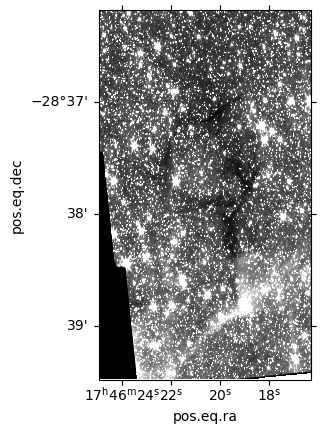

In [10]:
ax = plt.subplot(projection=ww)
ax.imshow(data, origin='lower', cmap='gray', vmin=0, vmax=50)


In [11]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))

# Remove Foreground and Bright Sources

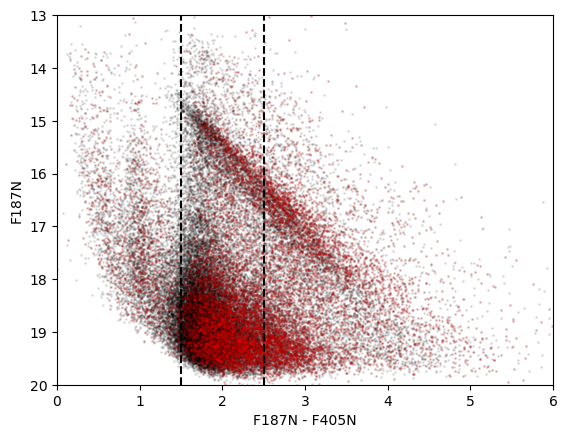

In [13]:
ax = plt.subplot()
cat_use.plot_CMD('f187n', 'f405n', 'f187n', alpha=0.1, s=1, c='k', ax=ax)
cat_filament.plot_CMD('f187n', 'f405n', 'f187n', alpha=0.11, s=1, c='r', ax=ax)
ax.set_xlim(0, 6)
ax.set_ylim(20, 13)
ax.axvline(1.5, color='k', linestyle='--')
ax.axvline(2.5, color='k', linestyle='--')

In [14]:
mask = (cat_filament.catalog['mag_ab_f187n'] > 15 | ~cat_filament.catalog['mag_ab_f187n'].mask)
mask &= cat_filament.catalog['mag_ab_f182m'] > 15 | ~cat_filament.catalog['mag_ab_f182m'].mask
mask &= cat_filament.catalog['mag_ab_f212n'] > 15 | ~cat_filament.catalog['mag_ab_f212n'].mask
mask &= np.logical_or(cat_filament.catalog['mag_ab_f410m'] > 13.25, ~cat_filament.catalog['mag_ab_f410m'].mask)
mask &= np.logical_or(cat_filament.catalog['mag_ab_f466n'] > 13.25, ~cat_filament.catalog['mag_ab_f466n'].mask)
mask &= np.logical_or(cat_filament.catalog['mag_ab_f405n'] > 13.25, ~cat_filament.catalog['mag_ab_f405n'].mask)
mask &= cat_filament.color('f187n', 'f405n') > 2#1.5
masked_cat = JWSTCatalog(cat_filament.apply_mask(mask))

(-2.5, 1.5)

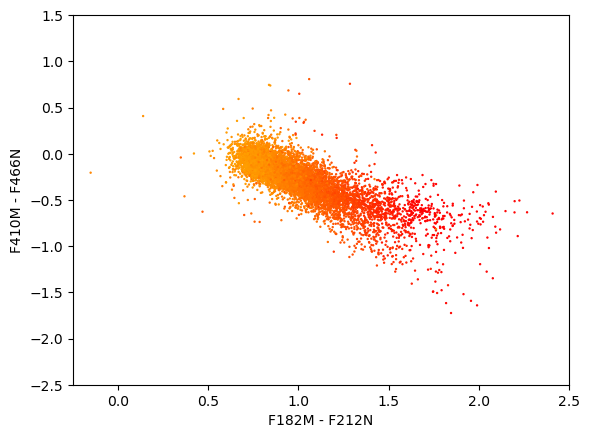

In [15]:
ax2 = plt.subplot(111)
masked_cat.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=masked_cat.color('f187n', 'f405n'), ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)
#ax2.legend()

# Making Grid

In [16]:
size = (w, l)
bins_ra = np.arange(0, size[1].to(u.arcsec).value, 1)
bins_dec = np.arange(0, size[0].to(u.arcsec).value, 1)

bins_pix_ra = bins_ra/ww.proj_plane_pixel_scales()[1].to(u.arcsec).value
bins_pix_dec = bins_dec/ww.proj_plane_pixel_scales()[0].to(u.arcsec).value

In [17]:
crds_pix = ww.all_world2pix(masked_cat.ra, masked_cat.dec, 0)

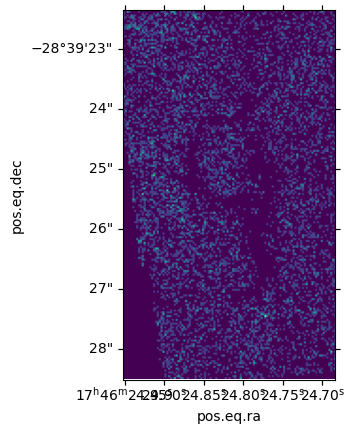

In [18]:
h, xedges, yedges = np.histogram2d(crds_pix[0], crds_pix[1], bins=[bins_pix_ra, bins_pix_dec])
ax = plt.subplot(111, projection=ww)
ax.imshow(h.swapaxes(0,1))

In [19]:
ext_cat = Table()
ext_cat['ra'] = masked_cat.ra
ext_cat['dec'] = masked_cat.dec
ext_cat['x'] = crds_pix[0]
ext_cat['y'] = crds_pix[1]
ext_cat['Av'] = masked_cat.get_Av_182410()
ext_cat['skycoord'] = masked_cat.catalog['skycoord_ref']

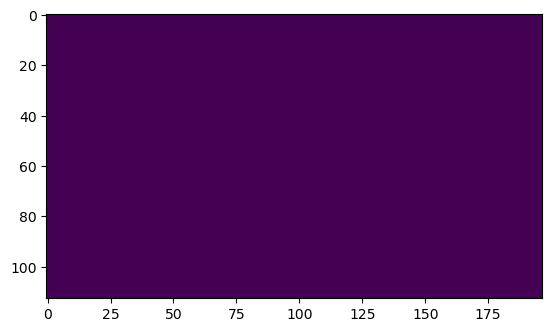

In [20]:
h_0 = np.zeros_like(h)
plt.imshow(h_0)

In [25]:
naxis1 = h_0.shape[0]
naxis2 = h_0.shape[1]

for i in range(naxis1):
    for j in range(naxis2):
        x = bins_pix_ra[i]+0.5
        y = bins_pix_dec[j]+0.5

        ra, dec = ww.wcs_pix2world(x, y, 0)

        pos = SkyCoord(ra, dec, unit=(u.deg, u.deg))

        seplimit = 1.5*u.arcsec
        idx = np.where(pos.separation(ext_cat['skycoord']) < seplimit)[0]

        nearest_stars = ext_cat[idx]

        avg_Av = np.mean(nearest_stars['Av'])

        h_0[i, j] = avg_Av

/scratch/local/44148503/ipykernel_2518098/3188155118.py:20: UserWarning: Warning: converting a masked element to nan.
  h_0[i, j] = avg_Av


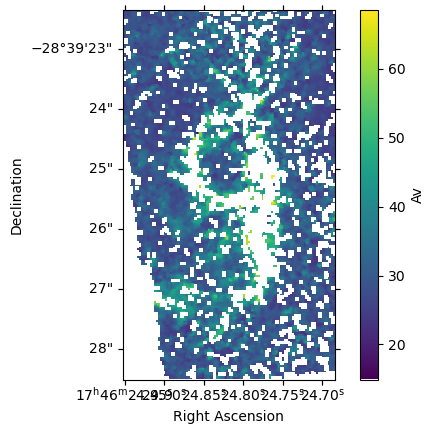

In [26]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_0.swapaxes(0,1))
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

plt.colorbar(im, label='Av', ax=ax)

In [27]:
from astropy.convolution import interpolate_replace_nans, Gaussian2DKernel

# Create a Gaussian kernel
gauss_kernel = Gaussian2DKernel(1)

# Interpolate the NaN values
h_1 = interpolate_replace_nans(h_0, gauss_kernel)


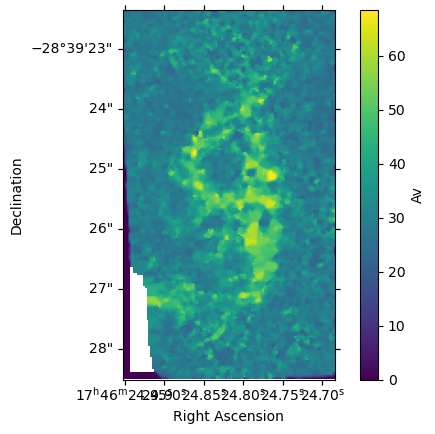

In [28]:
ax = plt.subplot(111, projection=ww)
im = ax.imshow(h_1.swapaxes(0,1), origin='lower')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.colorbar(im, label='Av', ax=ax)